## Run statistical test for tomographic and/or mantle flow models and plot mean distances and statistical test results.

In [1]:
import sys
# sys.path.insert(0,'C:/Users/annal/OneDrive/Documents/python3.8/pygplates_rev28_python38_win64')
# sys.path.insert(0,'/Users/omer/Documents/pygplates_rev18_python27_MacOS64')
sys.path.insert(0,'/Users/omer/Documents/pygplates_rev28_python38_MacOS64/')
sys.path.insert(1,'/Applications/GMT-6.0.0.app/Contents/Resources')
import pandas as pd

In [2]:
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import itertools
from scipy import stats
import statsmodels
import sys
from matplotlib.lines import Line2D
from call_system_command import call_system_command
import pandas as pd
import os.path
# %matplotlib inline

In [3]:
import pygplates
import numpy as np
import os
import math
import sphere_tools as sph
import matplotlib.pyplot as plt
import itertools
from scipy import stats
import statsmodels
import sys
from matplotlib.lines import Line2D
from call_system_command import call_system_command
%matplotlib inline

In [4]:
def find_number_of_LIPs(age,window,point_features):
    
    agemax = age+window
    agemin = age-window
    
    count = 0
    
    for p in point_features:
        
        # NB valid_time is a tuple, we take the first value since this is the 'birth' time of the LIP
        BirthTime = p.get_valid_time()[0] 
        
        if BirthTime <= agemax and BirthTime > agemin:
            
            count+=1
    
    return count

In [5]:
def get_volcanic_product_long_lat(rotations,anchor_plate_id,age,window,point_features):
    
    agemax = age+window
    agemin = age-window
    
    Xr = []
    Yr = []

    for p in point_features:
        
        # NB valid_time is a tuple, we take the first value since this is the 'birth' time of the Kimberlite
        BirthTime = p.get_valid_time()[0] 
        
        if BirthTime <= agemax and BirthTime > agemin:
            
            PlateID = p.get_reconstruction_plate_id()

            # Get rotation for the point and reconstruct to its birth time if it's in age interval (window)
            Kimb_rotation = rotations.get_rotation(age, PlateID, anchor_plate_id)

            reconstructed_point = Kimb_rotation * p.get_geometry()
            reconstructed_point_degrees = reconstructed_point.to_lat_lon_point()

            Xr.append(reconstructed_point_degrees.get_longitude())
            Yr.append(reconstructed_point_degrees.get_latitude())
    
    
    return Xr, Yr

In [6]:
# generic function to sample grids using grdtrack and read results
def sample_using_gmt(grdfile, point_lons, point_lats,OutputDirectory):

        dataout = np.vstack((np.asarray(point_lons),np.asarray(point_lats))).T

        np.savetxt(OutputDirectory+'/tmp.txt',dataout)
        
        # Note -nn forces nearest neighbour interpolation
        call_system_command(['gmt',
                             'grdtrack',
                             '%s/tmp.txt' %OutputDirectory,
                             '-G{:s}'.format(grdfile), 
                             '-fg',
                             '-nn',
                             '-V',
                             '>', 
                             '%s/tmp_interp.txt' % OutputDirectory])
        G=[]
        with open(OutputDirectory+'/tmp_interp.txt') as f:
            for line in f:
                if line[0] == '>':
                    continue
                else:
                    tmp = line.split()
                    G.append(float(tmp[2]))

        f.close()
        return np.array(G)

In [7]:
# 
def create_hot_nc_file(GridDirect,OutputDirect,TomogModelName,percentContourValue):
    
    GridFile="%s/%s.nc" %(GridDirect,TomogModelName)
    ContourFile="%s/%s_Contour.txt" %(OutputDirect,TomogModelName)
    TempGrid1="%s/%s_TempGrid1.nc" %(OutputDirect,TomogModelName)
    TempGrid2="%s/%s_TempGrid2.nc" %(OutputDirect,TomogModelName)
    hot_xyz_file="%s/%s_hot.xyz" %(OutputDirect,TomogModelName)
    
    DistanceFROMHot="%s/%s_Distance_to_Hot.nc" %(OutputDirect,TomogModelName)
    
    
    percentContourValueHigh=percentContourValue*(1.0+0.01)
    percentContourValueLow=percentContourValue*(1.0-0.01)
   
    call_system_command(['gmt',
                     'grdcontour',
                     GridFile,
                     '-D%s' % ContourFile,
                     '-C1',
                     '-L/%s/%s' % (str(percentContourValueLow),str(percentContourValueHigh))])

#                      '-L/-0.303/-0.297']) # This contour value was adapted for the purpose of the manuscript.
#                      '-L%.1f/%.1f',(percentContourValueLow,percentContourValueHigh)])
    
    call_system_command(['gmt',
                      'grdclip',
                     GridFile,
                     '-Rd',
                     '-Sa%.1f/1' % percentContourValue,
                     '-G%s' % TempGrid1])
    
    call_system_command(['gmt',
                      'grdclip',
                     TempGrid1,
                     '-Rd',
                     '-Sb1/0',
                     '-G%s' % TempGrid2])
    
    
    call_system_command(['gmt',
                         'grd2xyz',
                         TempGrid2,
                         '-Rd',
                         '-di1',  # set all cells with '1' to be nodata
                         '-s',
                         '>',
                         '%s' % hot_xyz_file])

    call_system_command(['gmt',
                         'grdmath',
                         TempGrid2,
                         '%s' % hot_xyz_file,
                         'PDIST',
                         'KM2DEG',
                         '=',
                         '%s' % DistanceFROMHot])

In [8]:
CurrentDirectory=!pwd
CurrentDirectory=str(CurrentDirectory)[2:-2]
CurrentDirectory # This is your current directory.

'/Users/omer/Documents/GitHub/The-Diamond-Route/Statistical-Analysis'

In [9]:
# CurrentDir=!pwd
# str(l)[1:-1]
'%s/Flow-Models/Case1' %CurrentDirectory

'/Users/omer/Documents/GitHub/The-Diamond-Route/Statistical-Analysis/Flow-Models/Case1'

In [10]:
# GridDirect="/Users/omer/Desktop/NatGeoReviews/Flow-Models/Case1/"
# OutputDirect="/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Flow-Model-Stats/Case1/WholeMantle/"
# FlowModel="Case1_WholeMantle"

GridDirect='%s/Flow-Models/Case1/' %CurrentDirectory
OutputDirect='%s/Flow-Model-Stats/Case1/WholeMantle/' %CurrentDirectory
FlowModel="Case1_WholeMantle"

#Create Grids If not created by uncommenting the lines below:

# "%s%s.nc" %(GridDirect,TomogModel)
# create_hot_nc_file(GridDirect,OutputDirect,TomogModel,-0.3)

In [11]:
def run_random_sampling(nPoints,age,dist_to_hot_nc_file,CalcOutputDir):
    
#     recon_label = '2017NNR'

#     basedir='/Users/omer/Documents/Programming/PyGplates/Supplement/Latest/M21NNR/NNR/NNR_InFiles/'
#     input_rotation_filename1 = '%s/1000-410_rotations-NNR.rot' % basedir
#     input_rotation_filename2 = '%s/Global_EB_410-250Ma_GK07_2017-NNR.rot' % basedir
#     input_rotation_filename3 = '%s/Global_EB_250-0Ma_GK07_2017-NNR.rot' % basedir
#     input_rotation_filename4 = '%s/NR_0Ma_1000Ma_for_gplates.rot' % basedir
#     rotation_model = pygplates.RotationModel([input_rotation_filename1,input_rotation_filename2,\
#                                               input_rotation_filename3,input_rotation_filename4])

#     ANCHOR_ID = int(0)
#     cratonFileDir='/Users/omer/Documents/Programming/PyGplates/Supplement/Reconstructions/M21NNR/'
#     cratonFile=cratonFileDir+"shapes_cratons_Merdith_et_al.gpml"
    
#     cratonFileDir='/Users/omer/Documents/Programming/PyGplates/Supplement/Reconstructions/NewCratonsForAnalysis/'
#     cratonFile=cratonFileDir+"cratons_150km_thick_with_plate_IDs_manually_edited.gpml"
    age=int(age)
    recon_label = 'M21'
    ReconstructionDir='%s/Reconstruction_Models/M21/' %CurrentDirectory
#     ReconstructionDir='/Users/omer/Desktop/NatGeoReviews/Reconstruction_Models/M21/'
    cratonFile=ReconstructionDir+"shapes_cratons_Merdith_et_al.gpml"
    cratons = pygplates.FeatureCollection(cratonFile)    

    input_rotation_filename = '%s/1000_0_rotfile_Merdith_et_al.rot' % ReconstructionDir
    ANCHOR_ID = int(0)
    
    rotation_model=pygplates.RotationModel(input_rotation_filename)

    randomLons = []
    randomLats = []
    random_pdist2hot = []
   
    
    # Start with an empty list of features
    features_to_modify = []
    new_features=[]
    reconstructed_feature_geometries=[]
    
    # Reconstruct cratonic shapes at Age Ma
    pygplates.reconstruct(cratons, rotation_model, reconstructed_feature_geometries, age)
    
#     print(reconstructed_feature_geometries)
#     print(age)
    
    RandomPoints_Lats=np.array([])
    RandomPoints_Lons=np.array([])
    
    totalRandomInsideCratons=0
    
    while(totalRandomInsideCratons<nPoints):
        random_point = sph.random_points_feature(1)
        for mp in random_point:
            for point in mp.get_geometry().get_points():
                pointInDegrees=point.to_lat_lon_point()
                PointLat=pointInDegrees.get_latitude()
                PointLon=pointInDegrees.get_longitude()
                
#                 for static_polygon in cratons:
                for static_polygon in reconstructed_feature_geometries:
#                     PlateID = static_polygon.get_reconstruction_plate_id()
#                     static_polygon_geom = static_polygon.get_geometry()
                    static_polygon_geom = static_polygon.get_reconstructed_geometry()
                    if static_polygon_geom != None:
                        if static_polygon_geom.is_point_in_polygon((PointLat,PointLon)):        
#                             print("inside")
                            RandomPoints_Lats=np.append(RandomPoints_Lats,PointLat)
                            RandomPoints_Lons=np.append(RandomPoints_Lons,PointLon)
                            totalRandomInsideCratons=totalRandomInsideCratons+1
                            cF=pygplates.Feature()
                            cF.set_geometry(point)
                            new_features.append(cF)
    output_feature_collection = pygplates.FeatureCollection(new_features)
#     output_feature_collection.write("Random_"+str(nPoints)+"_Points_onCratons_ForSEMUCB-WM1_"+str(age)+"_Ma.gpml")

    # for the point locations of interest, sample the distance grids
    # (and the original cluster boolean grid as a sanity check)
    random_pdist2hot = sample_using_gmt(dist_to_hot_nc_file, RandomPoints_Lons, RandomPoints_Lats,CalcOutputDir)
#     random_cluster_bool = sample_using_gmt(cluster_nc_file, RandomPoints_Lons, RandomPoints_Lats)
    
    return random_pdist2hot

In [12]:
# plt.rcParams['axes.linewidth'] = 1.5 #set the value globally
# # set tick width
# plt.rcParams['ytick.major.size'] = 5
# plt.rcParams['xtick.major.size'] = 5
# plt.rcParams['ytick.minor.size'] = 2.5
# plt.rcParams['xtick.major.width'] = 1.5
# #plt.rcParams['xtick.minor.size'] = 10
# plt.rcParams['ytick.minor.width'] = 1.5
# plt.rcParams['ytick.major.width'] = 1.5
# plt.rcParams["font.weight"] = "bold"
# plt.rcParams["axes.labelweight"] = "bold"

# hfont00 = {'fontname':'DejaVu Sans','fontsize':24,'fontweight':'bold'}
# hfont0 = {'fontname':'DejaVu Sans','fontsize':20,'fontweight':'bold'}
# hfont1 = {'fontname':'DejaVu Sans','fontsize':18,'fontweight':'bold'}
# hfont = {'fontname':'DejaVu Sans','fontsize':16,'fontweight':'bold'}
# hfont2 = {'fontname':'DejaVu Sans','fontsize':14,'fontweight':'bold'}
# %matplotlib inline

In [13]:
gr=1.618
5.5/gr

3.399258343634116

In [14]:
import warnings

## For UserWarning
def fxnUw():
    warnings.warn("UserWarning arose", UserWarning)

## For DeprecationWarning
def fxnDw():
    warnings.warn("deprecated", DeprecationWarning)

180 Ma
1.104413467294706 is the mean of the sample
55.88235294117647 % of the points are on Hot Structures
34
Random 1 out of 100
Random 11 out of 100
Random 21 out of 100
Random 31 out of 100
Random 41 out of 100
Random 51 out of 100
Random 61 out of 100
Random 71 out of 100
Random 81 out of 100
Random 91 out of 100
0.06 0.43  are ADFS_conf and ADFS_conf_0_25
n>30


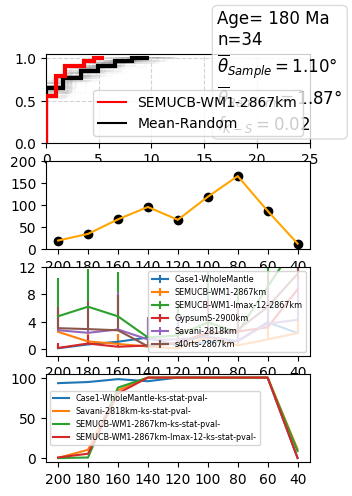

In [15]:

fig, axs = plt.subplots(4)
# cm = 1/2.54
# fig.set_size_inches(3.46457,5.118)
fig.set_size_inches(3.39925,5.3)


# fig.figsize=(13.0*cm,8.8*cm)



# root_dir = '/Users/omer/Documents/Programming/PyGplates/Supplement/Latest/'
# grid_dir = '/Users/omer/Documents/Programming/PyGplates/Supplement/Latest/'
# solid_plot_dir = '/Users/omer/Documents/Programming/PyGplates/Supplement/Latest/solid'
# KimberlitesFile='/Users/omer/Desktop/NatGeoReviews/Kimberlites/\
# Tappe-et-al-2018-EPSL-Kimberlite_emplacement_ages-automatic-part1-with-locations-with-plate-IDs.gpml'
KimberlitesFile='%s/Kimberlites/Tappe-et-al-2018-EPSL-Kimberlite_emplacement_\
ages-automatic-part1-with-locations-with-plate-IDs.gpml' %CurrentDirectory

pc = pygplates.FeatureCollection(KimberlitesFile)
window = 10
# Tmin = int(160)
# Tmax = int(320)
# Tmax = int(180)

# CalcOutputDir="/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Tomographic-Model-Stats/SEMUCB-WM1/2867km/"
# grid_dir="/Users/omer/Desktop/NatGeoReviews/Tomographic-Models/SEMUCB-WM1/"
# OutputDirect="/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Tomographic-Model-Stats/SEMUCB-WM1/2867km/"

CalcOutputDir="%s/Tomographic-Model-Stats/SEMUCB-WM1/2867km/" %CurrentDirectory
grid_dir="%s/Tomographic-Models/SEMUCB-WM1/"  %CurrentDirectory
OutputDirect="%s/Tomographic-Model-Stats/SEMUCB-WM1/2867km/"  %CurrentDirectory
TomogModelN="SEMUCB-WM1_2867"
# TomogModelN="SEMUCB-WM1_2867_lmax_12"

# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)   


recon_label = 'M21'

# ReconstructionDir='/Users/omer/Desktop/NatGeoReviews/Reconstruction_Models/M21/'
ReconstructionDir='%s/Reconstruction_Models/M21/'  %CurrentDirectory
cratonFile=ReconstructionDir+"shapes_cratons_Merdith_et_al.gpml"
cratons = pygplates.FeatureCollection(cratonFile)    


input_rotation_filename = '%s/1000_0_rotfile_Merdith_et_al.rot' % ReconstructionDir
ANCHOR_ID = int(0)

rotation_model=pygplates.RotationModel(input_rotation_filename)



# fig2, ax2 = plt.subplots()
# nTests=1000 # 1000 random tests were done in the manuscript.
nTests=100

# This sample test is only for 180 Ma, but can be modified to explore different times.
for Age in np.arange(180,160,-20):
#     fig, ax = plt.subplots()
    age = int(Age)
    print(Age, 'Ma')
    agemax = age+window
    agemin = age-window

    point_lats = []
    point_lons = []
    
    MIN_DISTANCE_HOT_DEG=[]
    MIN_SOLID_DISTANCE_DEG = []
    MIN_DISTANCE_HOT_DEG = []
    MIN_DISTANCE_HOT_DEG_STD = []

    DistancetoHot="%s/%s_Distance_to_Hot.nc" %(CalcOutputDir,TomogModelN)
        
    point_lons, point_lats = get_volcanic_product_long_lat(rotation_model,ANCHOR_ID,age,window,pc)

    pdist2hot = sample_using_gmt(DistancetoHot, point_lons, point_lats,CalcOutputDir)
    
    if len(pdist2hot) > 0:

#         CUMULATIVE_MIN_DISTANCE_HOT_DEG.extend(pdist2hot)
        MIN_DISTANCE_HOT_DEG=pdist2hot
        MIN_DISTANCE_HOT_DEG_STD=np.std(pdist2hot)
        
#     print(CUMULATIVE_MIN_DISTANCE_HOT_DEG_STD)
    
    MEAN_MIN_SOLID_DISTANCE_DEG = []
    
    MEDIAN_MIN_SOLID_DISTANCE_DEG = []

    
    
    MEDIAN_MIN_SOLID_DISTANCE_DEG = np.median(np.array(MIN_DISTANCE_HOT_DEG),axis=0)


    MEAN_MIN_SOLID_DISTANCE_DEG = np.mean(np.array(MIN_DISTANCE_HOT_DEG),axis=0)
    print(MEAN_MIN_SOLID_DISTANCE_DEG,'is the mean of the sample')
    
    # Calculate how many points are on Hot Structures -->
    k=np.asarray(MIN_DISTANCE_HOT_DEG)
    k=np.where(k<0.01,0.0,k)
    # np.where(np.asarray(CUMULATIVE_MIN_SOLID_DISTANCE_DEG) < 0.5)
    NumberOfPointsOnCold=np.count_nonzero(np.asarray(k))
    FractionOfPointsOnHotSOLIDCASE=100.0*(float(len(MIN_DISTANCE_HOT_DEG))-NumberOfPointsOnCold)/float(len(MIN_DISTANCE_HOT_DEG))
    print(FractionOfPointsOnHotSOLIDCASE,'% of the points are on Hot Structures')
    # --->
    
    
    
    #work out the random test
    ALL_MIN_RANDOM_SOLID_DISTANCE_DEG = []

    MEAN_MIN_RANDOM_SOLID_DISTANCE_DEG = []
    
    STD_MIN_RANDOM_SOLID_DISTANCE_DEG = []
    
    ALL_MIN_RANDOM_SOLID_DISTANCE_DEG_SORTED =[]
    
    ANDERSON_DARLING_STAT_ALL_RANDOM_SAMPLES_SOLID = []
    ANDERSON_DARLING_CONFIDENCE_ALL_RANDOM_SAMPLES_SOLID = []
    ANDERSON_DARLING_FIVE_PERCENT_ALL_RANDOM_SAMPLES_SOLID = []
    
    MEDIANS_ALL_RANDOM_SAMPLES_SOLID = []
    
    MEANS_ALL_RANDOM_SAMPLES_SOLID = []
    FRACTION_ANDERSON_DARLING_ALL_MODELS_SOLID_conf=[]
    FRACTION_ANDERSON_DARLING_ALL_MODELS_SOLID_5pc=[]
    FRACTION_SMALLER_MEDIANS_ALL_MODELS_SOLID=[]
    FRACTION_SMALLER_MEANS_ALL_MODELS_SOLID=[]
    FRACTION_MEDIANS_AD_ALL_MODELS_SOLID=[]
    FRACTION_MEANS_AD_ALL_MODELS_SOLID=[]
    MEAN_MEDIANS_ALL_MODELS_SOLID=[]
    MEDIAN_ALL_MODELS_SOLID=[]
    MEDIAN_RANDOM_TEST_ALL_MODELS_SOLID=[]
    CumulativeRand=[]

    numKimbs=int(len(MIN_DISTANCE_HOT_DEG))
    print(numKimbs)
    KOLMOGOROV_ALL_RANDOM_SAMPLES_SOLID_stat_two_sided=[]
    KOLMOGOROV_ALL_RANDOM_SAMPLES_SOLID_pval_two_sided=[]
    
    FRACTION_KOLMOGOROV_ALL_MODELS_SOLID_stat_two_sided=[]
    FRACTION_KOLMOGOROV_ALL_MODELS_SOLID_pval_two_sided=[]
    for m in range(nTests):
        
        if m % 10 == 0:
            print('Random', m+1, 'out of', nTests)
        
        MIN_RANDOM_DISTANCE_TO_HOT = []
        MIN_RANDOM_DISTANCE_TO_HOT_DEG = []
        MIN_RANDOM_SOLID_DISTANCE_DEG = []
    
        
        random_pdist2hot = run_random_sampling(numKimbs,Age,DistancetoHot,CalcOutputDir)
        
        if len(random_pdist2hot) > 0:

            MIN_RANDOM_DISTANCE_TO_HOT.extend(random_pdist2hot)

        MIN_RANDOM_SOLID_DISTANCE_DEG = MIN_RANDOM_DISTANCE_TO_HOT
        
        
        if(len(MIN_DISTANCE_HOT_DEG)==len(random_pdist2hot)):
            ALL_MIN_RANDOM_SOLID_DISTANCE_DEG.append(MIN_RANDOM_DISTANCE_TO_HOT)        
        else:
            print('MUTATION!')
#             random_pdist2hot = run_random_sampling(numKimbs,Age,DistancetoHot,CalcOutputDir)
    
            ALL_MIN_RANDOM_SOLID_DISTANCE_DEG=ALL_MIN_RANDOM_SOLID_DISTANCE_DEG

        MEANS_ALL_RANDOM_SAMPLES_SOLID.append(np.mean(np.array(MIN_RANDOM_SOLID_DISTANCE_DEG),axis=0))
       
        MEDIANS_ALL_RANDOM_SAMPLES_SOLID.append(np.median(np.array(MIN_RANDOM_SOLID_DISTANCE_DEG),axis=0))
 
        #plot the cumulative histogram
        n, bins, patches = axs[0].hist(MIN_RANDOM_SOLID_DISTANCE_DEG, bins='fd', density=True, histtype='step',
                                cumulative=True, color='grey', linewidth=0.2, zorder=1,alpha=0.20)

        patches[0].set_xy(patches[0].get_xy()[:-1])
        
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            fxnUw()
       
            AD1S, AD2S, AD3S = stats.anderson_ksamp([MIN_DISTANCE_HOT_DEG, 
                                                     MIN_RANDOM_SOLID_DISTANCE_DEG])


            ANDERSON_DARLING_STAT_ALL_RANDOM_SAMPLES_SOLID.append(AD1S)
            ANDERSON_DARLING_CONFIDENCE_ALL_RANDOM_SAMPLES_SOLID.append(AD3S)
    #         print(AD3S, "... confidence level")
            ANDERSON_DARLING_FIVE_PERCENT_ALL_RANDOM_SAMPLES_SOLID.append(AD2S[2])

            KS1tS, KS2tS = stats.ks_2samp(MIN_DISTANCE_HOT_DEG, MIN_RANDOM_SOLID_DISTANCE_DEG,
                                          alternative='two-sided', mode='exact')

            KOLMOGOROV_ALL_RANDOM_SAMPLES_SOLID_stat_two_sided.append(KS1tS)
            KOLMOGOROV_ALL_RANDOM_SAMPLES_SOLID_pval_two_sided.append(KS2tS)
        
    #work out the fraction of random tests for which the null hypothesis cannot be rejected,
    #i.e. the sample distribution significantly differs from the random distribution
    ADFS_conf=float(sum(i < 0.05 for i in ANDERSON_DARLING_CONFIDENCE_ALL_RANDOM_SAMPLES_SOLID))/float(len(ANDERSON_DARLING_CONFIDENCE_ALL_RANDOM_SAMPLES_SOLID))
    
    ADFS_conf_0_25=float(sum(i < 0.25 for i in ANDERSON_DARLING_CONFIDENCE_ALL_RANDOM_SAMPLES_SOLID))/float(len(ANDERSON_DARLING_CONFIDENCE_ALL_RANDOM_SAMPLES_SOLID))
    print(ADFS_conf,ADFS_conf_0_25, " are ADFS_conf and ADFS_conf_0_25")

    count_ADS=0
    for k in range(len(ANDERSON_DARLING_STAT_ALL_RANDOM_SAMPLES_SOLID)):
        if ANDERSON_DARLING_STAT_ALL_RANDOM_SAMPLES_SOLID[k]>ANDERSON_DARLING_FIVE_PERCENT_ALL_RANDOM_SAMPLES_SOLID[k]:
            count_ADS+=1
    
    ADFS_5pc=float(float(count_ADS)/float(len(ANDERSON_DARLING_FIVE_PERCENT_ALL_RANDOM_SAMPLES_SOLID)))
        

    FRACTION_ANDERSON_DARLING_ALL_MODELS_SOLID_conf_25pc=[]
    
    FRACTION_ANDERSON_DARLING_ALL_MODELS_SOLID_conf.append(ADFS_conf)
    FRACTION_ANDERSON_DARLING_ALL_MODELS_SOLID_5pc.append(ADFS_5pc)
    FRACTION_ANDERSON_DARLING_ALL_MODELS_SOLID_conf_25pc.append(ADFS_conf_0_25)
    

    p=0.05
    
    n=int(len(MIN_DISTANCE_HOT_DEG))
    
    if(n==19):
        KScritNEW=0.1280
        print("n=19")
    elif(n==12):
        KScritNEW=0.1287
        print("n=12")
    else:
        KScritNEW=math.sqrt(-1.0*(math.log(1-p))/2.0) -(1.0/6.0)*n**(-1.0/2.0) +1/n
        print("n>30")
   
    KSFS_stat_two_sided=float(sum(i > KScritNEW for i in KOLMOGOROV_ALL_RANDOM_SAMPLES_SOLID_stat_two_sided))/float(len(KOLMOGOROV_ALL_RANDOM_SAMPLES_SOLID_stat_two_sided))

    KSFS_pval_two_sided=float(sum(i < 0.05 for i in KOLMOGOROV_ALL_RANDOM_SAMPLES_SOLID_pval_two_sided))/float(len(KOLMOGOROV_ALL_RANDOM_SAMPLES_SOLID_pval_two_sided))
    
    countSmean_KS=0
    for l in range(nTests):
        
        #find the number of successful tests for the solid case
#         if KOLMOGOROV_ALL_RANDOM_SAMPLES_SOLID_stat_two_sided[l] < KScritNEW \
#         or KOLMOGOROV_ALL_RANDOM_SAMPLES_SOLID_pval_two_sided[l] > 0.05:
#             countSmean_KS+=1
        
        if (KOLMOGOROV_ALL_RANDOM_SAMPLES_SOLID_stat_two_sided[l] < KScritNEW):
            countSmean_KS+=1
        
    FRACTION_KS_Crit=float(1.0- countSmean_KS/nTests)
    
    countSmean_KS=0
    for l in range(nTests):
        
        if KOLMOGOROV_ALL_RANDOM_SAMPLES_SOLID_stat_two_sided[l] < KScritNEW \
        or KOLMOGOROV_ALL_RANDOM_SAMPLES_SOLID_pval_two_sided[l] > 0.05:
            countSmean_KS+=1
     
    FRACTION_KS_Crit_TwoCond=float(1.0- countSmean_KS/nTests)        
    
    
    
    #work out the fraction of random tests for which the median distance is greater than
    #in the sample distribution, i.e. sample points are closer to basal structures than
    #random points
    
    FRACTION_KOLMOGOROV_ALL_MODELS_SOLID_stat_two_sided.append(KSFS_stat_two_sided)
    
    
    FRACTION_KOLMOGOROV_ALL_MODELS_SOLID_pval_two_sided.append(KSFS_pval_two_sided)


    
    #work out the fraction of random tests for which the median distance is greater than
    #in the sample distribution, i.e. sample points are closer to basal structures than
    #random points
    
    FRACTION_SMALLER_MEDIANS_SOLID=float(sum(abs(i) > abs(MEDIAN_MIN_SOLID_DISTANCE_DEG) for i in MEDIANS_ALL_RANDOM_SAMPLES_SOLID))/float(len(MEDIANS_ALL_RANDOM_SAMPLES_SOLID))
   
    FRACTION_SMALLER_MEDIANS_ALL_MODELS_SOLID.append(FRACTION_SMALLER_MEDIANS_SOLID)
   
    FRACTION_SMALLER_MEANS_SOLID = float(sum(i > MEAN_MIN_SOLID_DISTANCE_DEG for i in MEANS_ALL_RANDOM_SAMPLES_SOLID))/float(len(MEANS_ALL_RANDOM_SAMPLES_SOLID))
   
    FRACTION_SMALLER_MEANS_ALL_MODELS_SOLID.append(FRACTION_SMALLER_MEANS_SOLID)
    
    
    countSmean=0 # 
#     countEmean=0
    countSmedian=0
    countSmeanWeak=0
#     countEmedian=0
    for l in range(nTests):
        if MEANS_ALL_RANDOM_SAMPLES_SOLID[l] >= MEAN_MIN_SOLID_DISTANCE_DEG \
        and ANDERSON_DARLING_STAT_ALL_RANDOM_SAMPLES_SOLID[l]>ANDERSON_DARLING_FIVE_PERCENT_ALL_RANDOM_SAMPLES_SOLID[l]:
            countSmean+=1
            
        if ANDERSON_DARLING_STAT_ALL_RANDOM_SAMPLES_SOLID[l]>ANDERSON_DARLING_FIVE_PERCENT_ALL_RANDOM_SAMPLES_SOLID[l]:
            countSmeanWeak+=1    
                
        if abs(MEDIANS_ALL_RANDOM_SAMPLES_SOLID[l]) >= abs(MEDIAN_MIN_SOLID_DISTANCE_DEG) \
        and ANDERSON_DARLING_STAT_ALL_RANDOM_SAMPLES_SOLID[l]>ANDERSON_DARLING_FIVE_PERCENT_ALL_RANDOM_SAMPLES_SOLID[l]:
            countSmedian+=1
            
    FRACTION_MEANS_AD_SOLID=float(float(countSmean)/float(nTests))
    FRACTION_MEANS_AD_SOLIDWeak=float(float(countSmeanWeak)/float(nTests))
    FRACTION_MEANS_AD_ALL_MODELS_SOLID.append(FRACTION_MEANS_AD_SOLID)

    FRACTION_MEDIANS_AD_SOLID=float(float(countSmedian)/float(nTests))
    FRACTION_MEDIANS_AD_ALL_MODELS_SOLID.append(FRACTION_MEDIANS_AD_SOLID)
    
#     print((100.0*float(countSmean)/nTests),' % of the time mean of the sample is less than random-Solid and Significantly Differs From Random')
    
    MEAN_MEDIANS_ALL_MODELS_SOLID.append(np.mean(np.array(MEDIANS_ALL_RANDOM_SAMPLES_SOLID),axis=0))
    
    #work out mean and median for the average of random samples for the solid case
    MEAN_MEAN_MIN_RANDOM_SOLID_DISTANCE_DEG = []
    MEDIAN_MEAN_MIN_RANDOM_SOLID_DISTANCE_DEG = []
    
    ALL_MIN_RANDOM_SOLID_DISTANCE_DEG_SORTED=np.sort(ALL_MIN_RANDOM_SOLID_DISTANCE_DEG, axis=-1,kind='stable')
    MEAN_MIN_RANDOM_SOLID_DISTANCE_DEG = np.mean(np.array(ALL_MIN_RANDOM_SOLID_DISTANCE_DEG_SORTED),axis=0)

#     below are the actual mim-max range
    MIN_MIN_RANDOM_SOLID_DISTANCE_DEG = np.amin(np.array(ALL_MIN_RANDOM_SOLID_DISTANCE_DEG_SORTED), axis=0)
    MAX_MIN_RANDOM_SOLID_DISTANCE_DEG = np.amax(np.array(ALL_MIN_RANDOM_SOLID_DISTANCE_DEG_SORTED), axis=0)
    
    MEAN_MEAN_MIN_RANDOM_SOLID_DISTANCE_DEG = np.mean(np.array(MEAN_MIN_RANDOM_SOLID_DISTANCE_DEG),axis=0)
    MEDIAN_MEAN_MIN_RANDOM_SOLID_DISTANCE_DEG = np.median(np.array(MEAN_MIN_RANDOM_SOLID_DISTANCE_DEG),axis=0)
            
    MEDIAN_ALL_MODELS_SOLID.append(MEDIAN_MIN_SOLID_DISTANCE_DEG)
    MEDIAN_RANDOM_TEST_ALL_MODELS_SOLID.append(MEDIAN_MEAN_MIN_RANDOM_SOLID_DISTANCE_DEG)
    
    
    
    n6, bins6, patches6 = axs[0].hist(MEAN_MIN_RANDOM_SOLID_DISTANCE_DEG, bins='fd', density=True, histtype='step',
                            cumulative=True, label='Mean-Random', color='black', linewidth=3, zorder=4)
    
    patches6[0].set_xy(patches6[0].get_xy()[:-1])

    
    #plot the cumulative histogram
#     a=np.asarray(MIN_SOLID_DISTANCE_DEG)
    a=np.asarray(MIN_DISTANCE_HOT_DEG)
    a=a.round(4)
    
    n7, bins7, patches7 = axs[0].hist(a, bins='fd', density=True, histtype='step',
                            cumulative=True, label='SEMUCB-WM1-2867km', color='red', linewidth=3, zorder=5)
        
    patches7[0].set_xy(patches7[0].get_xy()[:-1])
    
    # tidy up the figure

    #ax.grid(True)
#     ax.grid()
    axs[0].grid(zorder=0,linestyle='--', color='lightgrey')
#     ax.legend(loc='lower right')
    axs[0].set_xlim(0,25)
    #ax.set_title('Cumulative step histograms')
#     axs[0].set_xlabel('Minimum angular distance ($\degree$)')
#     axs[0].set_ylabel('Cumulative probability')
#     ax.set_title('{:s} (Solid)'.format(model_case))

    textstr = '\n'.join((
        r'Age= %i Ma' %(Age,),
        r'n=%i' %(numKimbs,),
        r'$\overline{\theta}_{Sample}=%.2f\degree$' % (MEAN_MIN_SOLID_DISTANCE_DEG, ),
        r'$\overline{\theta}_{Random}=%.2f\degree$' %(np.mean(MEANS_ALL_RANDOM_SAMPLES_SOLID), ),
        r'$f_{K-S}=%.2f$' %(KSFS_pval_two_sided),)) # based on pval.
#         r'$f_{A-D}=%.2f$' %(ADFS_conf))) # 5 percent sig.


#         r'${\kappa}_{\bar{\theta}}=%.2f$' % (FRACTION_SMALLER_MEANS_SOLID, )))
    props = dict(boxstyle='round', facecolor='white', alpha=0.80,edgecolor='lightgrey')
    #ax.grid(True)
#     ax.grid(zorder=0,linestyle='--', color='lightgrey')
    # Create new legend handles but use the colors from the existing ones
    handles, labels = axs[0].get_legend_handles_labels()
    new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
    axs[0].legend(handles=new_handles[::-1], labels=labels[::-1], loc='lower right')
    axs[0].text(0.65, 0.10, textstr, transform=axs[0].transAxes, fontsize=12,
            verticalalignment='bottom', bbox=props)
 
    axs[0].grid(zorder=1,linestyle='--', color='lightgrey')
    
#     fig.savefig('/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Tomographic-Model-Stats/SEMUCB-WM1/2867km/SEMUCB-WM1-2867-km-'+str(Age)+'-Ma-180MaOnly.pdf', 
#                 bbox_inches='tight', dpi=600)
    
#     plt.show()
    
#     OutputDir="/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Tomographic-Model-Stats/SEMUCB-WM1/\
#     Saved-Arrays"
    OutputDir="%s/Tomographic-Model-Stats/SEMUCB-WM1/Saved-Arrays" %CurrentDirectory
    np.save(OutputDir+'/SEMUCB-WM1-2867km-ks-stat-pval-'+str(Age)+'_Ma.npy',KSFS_pval_two_sided)
   
 ###


# recon_label = '2017NNR'

# basedir='/Users/omer/Documents/Programming/PyGplates/Supplement/Latest/M21NNR/NNR/NNR_InFiles/'
# input_rotation_filename1 = '%s/1000-410_rotations-NNR.rot' % basedir
# input_rotation_filename2 = '%s/Global_EB_410-250Ma_GK07_2017-NNR.rot' % basedir
# input_rotation_filename3 = '%s/Global_EB_250-0Ma_GK07_2017-NNR.rot' % basedir
# input_rotation_filename4 = '%s/NR_0Ma_1000Ma_for_gplates.rot' % basedir
# rotation_model = pygplates.RotationModel([input_rotation_filename1,input_rotation_filename2,\
#                                           input_rotation_filename3,input_rotation_filename4])

# ANCHOR_ID = int(0)
# age=200
# window=10

# # LIP_File="/Users/omer/Documents/Programming/PyGplates/Supplement/Volcanic_products/M21NNR/T18/T18_centroids_M21NNR_plateIDs.gpml"
# # LIP_File="/Users/omer/Documents/CitcomS_Assim_Models/Databases/T18_centroids_2017NNR_plateIDs.gpml"

# LIP_File='/Volumes/Accelsior4M2/ada2/KimberlitesReconstructed/Tappe-et-al-2018-EPSL-Kimberlite_emplacement_ages-automatic-part1-with-locations-with-plate-IDs.gpml'

# pc = pygplates.FeatureCollection(LIP_File)
# sumNLips=0
# for age in np.arange(200,20,-20):
    
#     nLIPs=find_number_of_LIPs(age,window,pc)
#     sumNLips=sumNLips+nLIPs
    
#     print(age,' Ma', nLIPs,' Kimberlites')
    
# # print(sumNLips)


NumKimbs=[19,34,67,95,66,118,165,86,12]
Ages=np.arange(200,20,-20)


# axes=plt.gca()
# plt.grid('minor')
# axes.figure.dpi=300
# axes.invert_xaxis()
axs[1].plot(Ages,NumKimbs,c='orange')
axs[1].scatter(Ages,NumKimbs,c='k')
axs[1].set_xticks(np.linspace(40,200,9))
axs[1].set_yticks(np.linspace(40,200,9))
axs[1].set_ylim(-1,180)
# plt.show()
# plt.savefig('KimbCountNew.pdf')

# ax.plot(x, y)
        
        
# BaseD="/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Flow-Model-Stats/"
BaseD="%s/Flow-Model-Stats/" %CurrentDirectory
Cases=["Case1"]
# Dpt=["UpperMantle","LowerMantle","WholeMantle"]
Dpt=["WholeMantle"]

Taki1="-MIN-DISTANCES_"
meanArray=[]
LineWidth=1.5
Age=200
# plt.gca()
# plt.close()
cm = 1/2.54


# for tm in Cases:
tm="Case1"    
    # plt.ylim(-5,105)
    
for d in Dpt: 
    if os.path.exists(BaseD+tm+"/Saved-Arrays/"+tm+"-"+d+Taki1+str(Age)+"_Ma.txt")==True:
#             print(BaseD+tm+"/Saved-Arrays/"+tm+"-"+d+Taki1+str(Age)+"_Ma.txt")
        meanArray=[]
        stdArray=[]
#                 Ex=np.append(Ex,BaseD+tm+"/Saved-Arrays/"+tm+"-"+d+Taki1+str(Age)+"_Ma.txt")
        for Age in np.arange(200,20,-20):
            df = pd.read_csv(BaseD+tm+"/Saved-Arrays/"+tm+"-"+d+Taki1+str(Age)+"_Ma.txt",
                             skiprows=0,header=None,sep=',')
            stdArray=np.append(stdArray,df.std()[0])
            meanArray=np.append(meanArray,df.mean()[0])

#             plt.plot(np.arange(200,20,-20),meanArray,label=tm+"-"+d)
        ErLow=np.zeros(len(stdArray))
        ErLowS=np.stack([ErLow,stdArray])
        axs[2].errorbar(np.arange(200,20,-20),meanArray, yerr=ErLowS,label=tm+"-"+d,linewidth=LineWidth)
    else:
        continue

        
        
        
        
        
        
#     plt.gca().invert_yaxis()


# BaseD="/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Tomographic-Model-Stats/"
BaseD="%s/Tomographic-Model-Stats/" %CurrentDirectory
tm="SEMUCB-WM1"
# Dpt=["2541km","2867km"]
Dpt=["2867km"]


Taki1="-MIN-DISTANCES_"
meanArray=[]

for d in Dpt: 
    if os.path.exists(BaseD+tm+"/Saved-Arrays/"+tm+"-"+d+Taki1+str(Age)+"_Ma.txt")==True:
#             print(BaseD+tm+"/Saved-Arrays/"+tm+"-"+d+Taki1+str(Age)+"_Ma.txt")
        meanArray=[]
        stdArray=[]
#                 Ex=np.append(Ex,BaseD+tm+"/Saved-Arrays/"+tm+"-"+d+Taki1+str(Age)+"_Ma.txt")
        for Age in np.arange(200,20,-20):
            df = pd.read_csv(BaseD+tm+"/Saved-Arrays/"+tm+"-"+d+Taki1+str(Age)+"_Ma.txt",
                             skiprows=0,header=None,sep=',')
            stdArray=np.append(stdArray,df.std()[0])
            meanArray=np.append(meanArray,df.mean()[0])

#             plt.plot(np.arange(200,20,-20),meanArray,label=tm+"-"+d)
        ErLow=np.zeros(len(stdArray))
        ErLowS=np.stack([ErLow,stdArray])
        axs[2].errorbar(np.arange(200,20,-20),meanArray, yerr=ErLowS,label=tm+"-"+d,linewidth=LineWidth)
    else:
        continue
        
# BaseD="/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Tomographic-Model-Stats/"
BaseD="%s/Tomographic-Model-Stats/" %CurrentDirectory
tm="SEMUCB-WM1"
# Dpt=["2541km","2867km"]
Dpt=["2867km"]


Taki1="-lmax-12-MIN-DISTANCES_"
meanArray=[]

for d in Dpt: 
    if os.path.exists(BaseD+tm+"/Saved-Arrays/"+tm+"-"+d+Taki1+str(Age)+"_Ma.txt")==True:
#             print(BaseD+tm+"/Saved-Arrays/"+tm+"-"+d+Taki1+str(Age)+"_Ma.txt")
        meanArray=[]
        stdArray=[]
#                 Ex=np.append(Ex,BaseD+tm+"/Saved-Arrays/"+tm+"-"+d+Taki1+str(Age)+"_Ma.txt")
        for Age in np.arange(200,20,-20):
            df = pd.read_csv(BaseD+tm+"/Saved-Arrays/"+tm+"-"+d+Taki1+str(Age)+"_Ma.txt",
                             skiprows=0,header=None,sep=',')
            stdArray=np.append(stdArray,df.std()[0])
            meanArray=np.append(meanArray,df.mean()[0])

#             plt.plot(np.arange(200,20,-20),meanArray,label=tm+"-"+d)
        ErLow=np.zeros(len(stdArray))
        ErLowS=np.stack([ErLow,stdArray])
        axs[2].errorbar(np.arange(200,20,-20),meanArray, yerr=ErLowS,label=tm+"-lmax-12-"+d,linewidth=LineWidth)
    else:
        continue


tm="GypsumS"
# Dpt=["2500km","2900km"]
Dpt=["2900km"]


Taki1="-MIN-DISTANCES_"
# print()
for d in Dpt: 
    if os.path.exists(BaseD+tm+"/Saved-Arrays/"+tm+"-"+d+Taki1+str(Age)+"_Ma.txt")==True:
#             print(BaseD+tm+"/Saved-Arrays/"+tm+"-"+d+Taki1+str(Age)+"_Ma.txt")
        meanArray=[]
        stdArray=[]
#                 Ex=np.append(Ex,BaseD+tm+"/Saved-Arrays/"+tm+"-"+d+Taki1+str(Age)+"_Ma.txt")
        for Age in np.arange(200,20,-20):
            df = pd.read_csv(BaseD+tm+"/Saved-Arrays/"+tm+"-"+d+Taki1+str(Age)+"_Ma_DiffCratons.txt",
                             skiprows=0,header=None,sep=',')
            stdArray=np.append(stdArray,df.std()[0])
            meanArray=np.append(meanArray,df.mean()[0])

#             plt.plot(np.arange(200,20,-20),meanArray,label=tm+"-"+d)
        ErLow=np.zeros(len(stdArray))
        ErLowS=np.stack([ErLow,stdArray])
        axs[2].errorbar(np.arange(200,20,-20),meanArray, yerr=ErLowS,label=tm+"-"+d,linewidth=LineWidth)
    else:
        continue



tm="Savani"
# Dpt=["2520km","2818km"]
Dpt=["2818km"]


Taki1="-MIN-DISTANCES_"
for d in Dpt: 
    if os.path.exists(BaseD+tm+"/Saved-Arrays/"+tm+"-"+d+Taki1+str(Age)+"_Ma.txt")==True:
#             print(BaseD+tm+"/Saved-Arrays/"+tm+"-"+d+Taki1+str(Age)+"_Ma.txt")
        meanArray=[]
        stdArray=[]
#                 Ex=np.append(Ex,BaseD+tm+"/Saved-Arrays/"+tm+"-"+d+Taki1+str(Age)+"_Ma.txt")
        for Age in np.arange(200,20,-20):
            df = pd.read_csv(BaseD+tm+"/Saved-Arrays/"+tm+"-"+d+Taki1+str(Age)+"_Ma_DiffCratons.txt",
                             skiprows=0,header=None,sep=',')
            stdArray=np.append(stdArray,df.std()[0])
            meanArray=np.append(meanArray,df.mean()[0])

#             plt.plot(np.arange(200,20,-20),meanArray,label=tm+"-"+d)
        ErLow=np.zeros(len(stdArray))
        ErLowS=np.stack([ErLow,stdArray])
        axs[2].errorbar(np.arange(200,20,-20),meanArray, yerr=ErLowS,label=tm+"-"+d,linewidth=LineWidth)
    else:
        continue



tm="s40rts"
# Dpt=["2520km","2818km"]
Dpt=["2867km"]


Taki1="-MIN-DISTANCES_"
for d in Dpt: 
    if os.path.exists(BaseD+tm+"/Saved-Arrays/"+tm+"-"+d+Taki1+str(Age)+"_Ma.txt")==True:
#             print(BaseD+tm+"/Saved-Arrays/"+tm+"-"+d+Taki1+str(Age)+"_Ma.txt")
        meanArray=[]
        stdArray=[]
#                 Ex=np.append(Ex,BaseD+tm+"/Saved-Arrays/"+tm+"-"+d+Taki1+str(Age)+"_Ma.txt")
        for Age in np.arange(200,20,-20):
            df = pd.read_csv(BaseD+tm+"/Saved-Arrays/"+tm+"-"+d+Taki1+str(Age)+"_Ma_DiffCratons.txt",
                             skiprows=0,header=None,sep=',')
            stdArray=np.append(stdArray,df.std()[0])
            meanArray=np.append(meanArray,df.mean()[0])

#             plt.plot(np.arange(200,20,-20),meanArray,label=tm+"-"+d)
        ErLow=np.zeros(len(stdArray))
        ErLowS=np.stack([ErLow,stdArray])
        axs[2].errorbar(np.arange(200,20,-20),meanArray, yerr=ErLowS,label=tm+"-"+d,linewidth=LineWidth)
    else:
        continue




# BaseD="/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Flow-Model-Stats/"
BaseD="%s/Flow-Model-Stats/" %CurrentDirectory
Cases=["Case1",]
Dpt=["WholeMantle"]
PerfArray=[]
Age=200
endAge=20
for cs in Cases:
    for d in Dpt:
        PerfArray=[]
        for Age in np.arange(200,endAge,-20):
            Succes=np.load(BaseD+cs+"/Saved-Arrays/"+cs+"-"+d+"-ks-stat-pval-"+str(Age)+"_Ma.npy")
#             print(d, BaseD+cs+"/Saved-Arrays/"+cs+"-"+d+"-ks-stat-pval-"+str(Age)+"_Ma.npy")
            PerfArray=np.append(PerfArray,Succes)
        axs[3].plot(np.arange(200,endAge,-20),100*PerfArray,label=cs+"-"+d+'-ks-stat-pval-',linewidth=LineWidth)

        
        
# BaseD="/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Tomographic-Model-Stats/"
BaseD="%s/Tomographic-Model-Stats/" %CurrentDirectory
Cases=["GypsumS/2900km"]
# Dpt=["WholeMantle","UpperMantle","LowerMantle"]


PerfArray=[]

Age=200
endAge=20
for cs in Cases:


    PerfArray=[]
    for Age in np.arange(200,endAge,-20):
        Succes=np.load(BaseD+cs[:-7]+"/Saved-Arrays/"+cs[:-7]+"-"+cs[-6:]+"-ks-stat-pval-"+str(Age)+"_Ma_DiffCratons.npy")
        PerfArray=np.append(PerfArray,Succes)
#     axs[3].plot(np.arange(200,endAge,-20),100*PerfArray,label=cs[:-7]+"-"+cs[-6:]+'-ks-stat-pval-',linewidth=LineWidth)

#             


# BaseD="/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Tomographic-Model-Stats/"
BaseD="%s/Tomographic-Model-Stats/" %CurrentDirectory
Cases=["s40rts/2867km"]
# Dpt=["WholeMantle","UpperMantle","LowerMantle"]


PerfArray=[]

Age=200
endAge=20
for cs in Cases:

    PerfArray=[]
    for Age in np.arange(200,endAge,-20):
        Succes=np.load(BaseD+cs[:-7]+"/Saved-Arrays/"+cs[:-7]+"-"+cs[-6:]+"-ks-stat-pval-"+str(Age)+"_Ma_DiffCratons.npy")
        PerfArray=np.append(PerfArray,Succes)
#     axs[3].plot(np.arange(200,endAge,-20),100*PerfArray,label=cs[:-7]+"-"+cs[-6:]+'-ks-stat-pval-',linewidth=LineWidth)

#           Savani/2520km  
    
# BaseD="/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Tomographic-Model-Stats/"
Cases=["Savani/2818km"]
# Dpt=["WholeMantle","UpperMantle","LowerMantle"]


PerfArray=[]

Age=200
endAge=20
for cs in Cases:

    PerfArray=[]
    for Age in np.arange(200,endAge,-20):
        Succes=np.load(BaseD+cs[:-7]+"/Saved-Arrays/"+cs[:-7]+"-"+cs[-6:]+"-ks-stat-pval-"+str(Age)+"_Ma_DiffCratons.npy")
        PerfArray=np.append(PerfArray,Succes)
    axs[3].plot(np.arange(200,endAge,-20),100*PerfArray,label=cs[:-7]+"-"+cs[-6:]+'-ks-stat-pval-',linewidth=LineWidth)

# SEMUCB-WM1/2541km

# BaseD="/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Tomographic-Model-Stats/"
Cases=["SEMUCB-WM1/2867km"]
# Dpt=["WholeMantle","UpperMantle","LowerMantle"]


PerfArray=[]

Age=200
endAge=20
for cs in Cases:

    PerfArray=[]
    for Age in np.arange(200,endAge,-20):
        Succes=np.load(BaseD+cs[:-7]+"/Saved-Arrays/"+cs[:-7]+"-"+cs[-6:]+"-ks-stat-pval-"+str(Age)+"_Ma_DiffCrat.npy")
        PerfArray=np.append(PerfArray,Succes)
    axs[3].plot(np.arange(200,endAge,-20),100*PerfArray,label=cs[:-7]+"-"+cs[-6:]+'-ks-stat-pval-',linewidth=LineWidth)


    
    
# BaseD="/Users/omer/Desktop/NatGeoReviews/Statistical-Analysis/Tomographic-Model-Stats/"
Cases=["SEMUCB-WM1/2867km"]
# Dpt=["WholeMantle","UpperMantle","LowerMantle"]


PerfArray=[]

Age=200
endAge=20
for cs in Cases:

    PerfArray=[]
    for Age in np.arange(200,endAge,-20):
        Succes=np.load(BaseD+cs[:-7]+"/Saved-Arrays/"+cs[:-7]+"-"+cs[-6:]+"-lmax-12-ks-stat-pval-"+str(Age)+"_Ma.npy")
        PerfArray=np.append(PerfArray,Succes)
    axs[3].plot(np.arange(200,endAge,-20),100*PerfArray,label=cs[:-7]+"-"+cs[-6:]+'-lmax-12-ks-stat-pval-',linewidth=LineWidth)


axs[0].set_yticks([0,0.5,1])

axs[1].invert_xaxis()
axs[1].set_yticks([0,50,100,150,200])
axs[1].set_xticks([200,180,160,140,120,100,80,60,40])


# axs[1].grid()

axs[2].invert_xaxis()
axs[2].set_ylim([-1,12])
axs[2].set_yticks([0,4,8,12])
axs[2].set_xticks([200,180,160,140,120,100,80,60,40])
# axs[2].grid()
axs[2].legend(fontsize='xx-small')


axs[3].invert_xaxis()
# axs[3].grid()
axs[3].legend(fontsize='xx-small')
axs[3].set_ylim([-5,105])
axs[3].set_yticks([0,50,100])
axs[3].set_xticks([200,180,160,140,120,100,80,60,40])


# fig.savefig('ORNEK-Stats-18-Oct-2022-.pdf',dpi=300)




# The End